In [3]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [4]:
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/processed'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
COLORS  = {
    'Eastern Arabian Sea':'blood',
    'Central India':'#D42028',
    'Central Bay of Bengal':'#F2C85E',
    'Equatorial Indian Ocean':'#5BA7DA',
    'Konkan Coast':'#1B2C61'}
SAMPLETHRESH = 50

In [6]:
def open_dataset(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds

In [8]:
stats = open_dataset('binned_stats.nc')

In [10]:
def get_bin_mean_pr(stats,bintype='1D',samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        coords = {'bl':stats.bl.values}
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
    if bintype=='2D':
        coords = {'subsat':stats.subsat.values,'cape':stats.cape.values}
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
    return xr.DataArray(binmeanpr,coords=coords)

def get_joint_hist(stats):
    PE = stats.PE.values
    P0 = stats.P0.values
    capebins   = stats.cape.values
    subsatbins = stats.subsat.values
    jointhist  = PE/(np.nansum(P0)*np.diff(subsatbins)[0]*np.diff(capebins)[0])
    subsatmaxidx,capemaxidx = np.where(PE==np.nanmax(PE))
    subsatmaxidx,capemaxidx = subsatmaxidx[0],capemaxidx[0]
    return xr.DataArray(jointhist,coords={'subsat':stats.subsat.values,'cape':stats.cape.values}),subsatmaxidx,capemaxidx

def get_thermo_ratio(stats,bintype='2D',samplethresh=SAMPLETHRESH):
    capebins   = stats.cape.values
    subsatbins = stats.subsat.values
    jointhist,subsatmaxidx,capemaxidx = get_joint_hist(stats)
    binmeanpr  = get_bin_mean_pr(stats,bintype,samplethresh=SAMPLETHRESH)
    while np.isnan(binmeanpr[:subsatmaxidx,:]).all():
        subsatmaxidx = subsatmaxidx+1
        if subsatmaxidx>subsatbins.size-1:
            print('Could not locate point for precipitation sensitivity computation.')
            break
    pra = np.copy(binmeanpr)
    prb = np.copy(binmeanpr)
    prc = np.copy(binmeanpr)
    pra[:] = np.nan
    prb[:] = np.nan
    prc[:] = np.nan
    pra[:subsatmaxidx,capemaxidx:]   = binmeanpr[:subsatmaxidx,capemaxidx:]
    prb[:subsatmaxidx,:capemaxidx+1] = binmeanpr[:subsatmaxidx,:capemaxidx+1]
    prc[subsatmaxidx-1:,capemaxidx:] = binmeanpr[subsatmaxidx-1:,capemaxidx:]
    maska = (np.where(np.isfinite(pra)))
    maskb = (np.where(np.isfinite(prb)))
    maskc = (np.where(np.isfinite(prc)))
    capea   = capebins[maska[1]]
    capeb   = capebins[maskb[1]]
    subsata = subsatbins[maska[0]]
    subsatc = subsatbins[maskc[0]]
    dprcape   = abs(np.nanmean(pra)-np.nanmean(prb))
    dprsubsat = abs(np.nanmean(pra)-np.nanmean(prc))
    dcape     = abs(capea.mean()-capeb.mean())
    dsubsat   = abs(subsata.mean()-subsatc.mean())
    gamma    = np.sqrt(((dprcape/dcape)**2)+((dprsubsat/dsubsat)**2))
    tantheta = (dprcape/dcape)*(dsubsat/dprsubsat)
    return np.arctan(tantheta),gamma

In [ ]:
arrowkwargs = dict(scale_units='xy',angles='xy',scale=1,width=0.015,headlength=2,headaxislength=2)
bound   = np.deg2rad(34.7)
rvalues = np.linspace(0,20,100)  

Eastern Arabian Sea:
- theta: 33.4 to 38.4
- gamma: 15.4 to 15.0
Central India:
- theta: 22.3 to 12.6
- gamma: 3.6 to 4.6
Central Bay of Bengal:
- theta: 49.3 to 42.8
- gamma: 17.6 to 12.6
Equatorial Indian Ocean:
- theta: 47.0 to 0.0
- gamma: 14.2 to 4.4
Konkan Coast:
- theta: 35.1 to 33.2
- gamma: 12.7 to 16.7


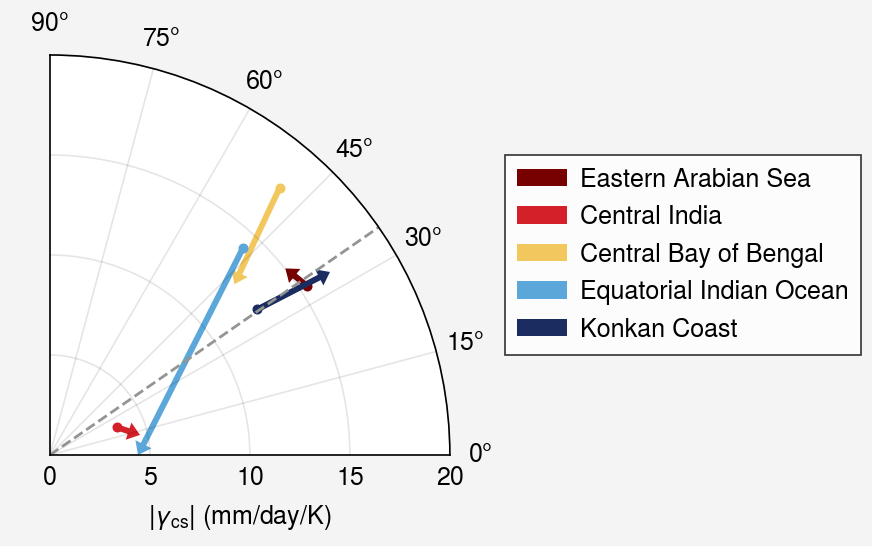

In [17]:
fig,ax = pplt.subplots(nrows=1,ncols=1,proj='polar',refheight=2,refwidth=2)
fig.text(x=0.17,y=0.04,s='|$\mathit{\gamma}_{cs}$| (mm/day/K)')
ax.plot([bound,bound],[0,rvalues[-1]],color='gray',linestyle='--',linewidth=1)
for i,(region,color) in enumerate(COLORS.items()):
    startmonth = 6 if i<3 else 7
    endmonth   = 7 if i<3 else 8
    startstats = stats.sel(region=region,month=startmonth)
    endstats   = stats.sel(region=region,month=endmonth)
    starttheta,startgamma = get_thermo_ratio(startstats)
    endtheta,endgamma = get_thermo_ratio(endstats)
    print(f'{region}:\n- theta: {np.rad2deg(starttheta):.1f} to {np.rad2deg(endtheta):.1f}\n- gamma: {startgamma:.1f} to {endgamma:.1f}')
    thetadiff = endtheta-starttheta
    gammadiff = endgamma-startgamma
    ax.scatter(starttheta,startgamma,color=color,marker='.')
    ax.quiver(starttheta,startgamma,thetadiff,gammadiff,color=color,label=region,**arrowkwargs)
ax.format(thetadir='anticlockwise',thetalines=15,thetalim=(0,90),rlim=(0,20))
ax.legend(loc='r',ncols=1)
ax.set_rticks([0,5,10,15,20])

pplt.show()
fig.save(f'{SAVEDIR}/fig_3.png',dpi=600)